In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    make_scorer
)


In [ ]:
data = pd.read_csv("katowice.csv")

In [3]:
X = data.drop(columns=["price"])
y = data["price"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
results_tuned = []

In [ ]:
def tune_and_evaluate(
    name,
    model,
    param_grid,
    X_train,
    X_test,
    y_train,
    y_test,
    search_type='random',  # 'grid' lub 'random'
    use_log_target=False,
    n_iter=25,
    cv=3,
    verbose=1,
    scoring='neg_root_mean_squared_error'
):

    # logarytmowanie zmiennej celu
    if use_log_target:
        y_train_fit = np.log1p(y_train)
        y_test_eval = np.expm1(np.log1p(y_test))
    else:
        y_train_fit = y_train
        y_test_eval = y_test

    # scorer
    if scoring == 'neg_root_mean_squared_error':
        scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    else:
        scorer = scoring

    # wybór grid vs random
    if search_type == 'random':
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring=scorer,
            cv=cv,
            verbose=verbose,
            n_jobs=-1,
            random_state=42
        )
    else:
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scorer,
            cv=cv,
            verbose=verbose,
            n_jobs=-1
        )

    search.fit(X_train, y_train_fit)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    if use_log_target:
        y_pred = np.expm1(y_pred)

    mae = mean_absolute_error(y_test_eval, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred))
    mean_price = np.mean(y_test_eval)

    mae_norm = mae / mean_price
    rmse_norm = rmse / mean_price
    r2 = r2_score(y_test_eval, y_pred)
    mape = np.mean(np.abs((y_test_eval - y_pred) / y_test_eval)) * 100

    print(f"\n📊 {name}")
    print("Najlepsze parametry:", search.best_params_)
    print(f"R²: {r2:.4f}")
    print(f"Znormalizowane MAE: {mae_norm:.4f}")
    print(f"Znormalizowane RMSE: {rmse_norm:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # wynik do tabeli
    return best_model, {
        "Model": name,
        "MAE_norm": mae_norm,
        "RMSE_norm": rmse_norm,
        "R2": r2,
        "MAPE": mape,
        "Best_Params": search.best_params_
    }


In [7]:
xgb_model = XGBRegressor(random_state=42)
xgb_params = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
_, res = tune_and_evaluate("XGBoost", xgb_model, xgb_params, X_train, X_test, y_train, y_test)
results_tuned.append(res)


Fitting 3 folds for each of 25 candidates, totalling 75 fits

📊 XGBoost
Najlepsze parametry: {'subsample': 0.8, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
R²: 0.8709
Znormalizowane MAE: 0.0958
Znormalizowane RMSE: 0.1315
MAPE: 10.24%


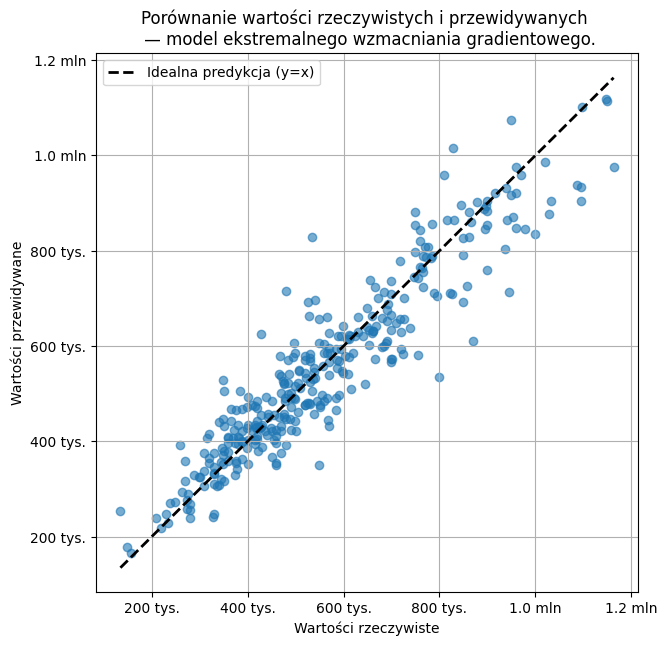

In [ ]:
best_params = res["Best_Params"]

# Tworzymy nowy model z najlepszymi parametrami
xgb_best_model = XGBRegressor(
    **best_params,
    random_state=42
)
# Trenujemy na tych samych danych
xgb_best_model.fit(X_train, y_train)
# Predykcje
y_pred_gb = xgb_best_model.predict(X_test)


plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_gb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Idealna predykcja (y=x)")
plt.xlabel("Wartości rzeczywiste")
plt.ylabel("Wartości przewidywane")
plt.title("Porównanie wartości rzeczywistych i przewidywanych \n — model ekstremalnego wzmacniania gradientowego.")
plt.legend()
plt.grid(True)

def custom_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000} mln'
    else:
        return f'{int(x/1000)} tys.'

axes = plt.gca()
axes.xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))

plt.show()


In [44]:
_, res = tune_and_evaluate("XGBoost (log)", xgb_model, xgb_params,
                           X_train, X_test, y_train, y_test, use_log_target=True)
results_tuned.append(res)


Fitting 3 folds for each of 25 candidates, totalling 75 fits

📊 XGBoost (log)
Najlepsze parametry: {'subsample': 0.6, 'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
R²: 0.8427
Znormalizowane MAE: 0.0960
Znormalizowane RMSE: 0.1452
MAPE: 10.03%


In [33]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_params = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}
_, res = tune_and_evaluate("Gradient Boosting", gbr_model, gbr_params,
                           X_train, X_test, y_train, y_test)
results_tuned.append(res)


Fitting 3 folds for each of 25 candidates, totalling 75 fits

📊 Gradient Boosting
Najlepsze parametry: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05}
R²: 0.8583
Znormalizowane MAE: 0.0964
Znormalizowane RMSE: 0.1378
MAPE: 10.18%


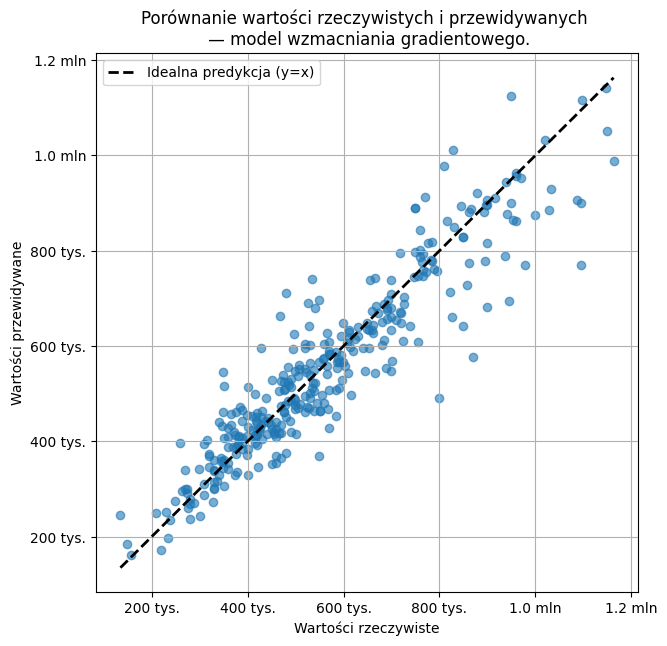

In [ ]:

best_params = res["Best_Params"]

# Tworzymy nowy model z najlepszymi parametrami
gb_best_model = GradientBoostingRegressor(
    **best_params,
    random_state=42
)
# Trenujemy na tych samych danych
gb_best_model.fit(X_train, y_train)
# Predykcje
y_pred_gb = gb_best_model.predict(X_test)


plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_gb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Idealna predykcja (y=x)")
plt.xlabel("Wartości rzeczywiste")
plt.ylabel("Wartości przewidywane")
plt.title("Porównanie wartości rzeczywistych i przewidywanych \n — model wzmacniania gradientowego.")
plt.legend()
plt.grid(True)

def custom_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000} mln'
    else:
        return f'{int(x/1000)} tys.'

axes = plt.gca()
axes.xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))

plt.show()


In [46]:
_, res = tune_and_evaluate("Gradient Boosting (log)", gbr_model, gbr_params,
                           X_train, X_test, y_train, y_test, use_log_target=True)
results_tuned.append(res)


Fitting 3 folds for each of 25 candidates, totalling 75 fits

📊 Gradient Boosting (log)
Najlepsze parametry: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05}
R²: 0.8326
Znormalizowane MAE: 0.0978
Znormalizowane RMSE: 0.1498
MAPE: 10.14%


In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
_, res = tune_and_evaluate("Random Forest", rf_model, rf_params,
                           X_train, X_test, y_train, y_test)
results_tuned.append(res)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l


📊 Random Forest
Najlepsze parametry: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
R²: 0.8371
Znormalizowane MAE: 0.1046
Znormalizowane RMSE: 0.1477
MAPE: 11.60%


In [48]:
_, res = tune_and_evaluate("Random Forest (log)", rf_model, rf_params,
                           X_train, X_test, y_train, y_test, use_log_target=True)
results_tuned.append(res)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l


📊 Random Forest (log)
Najlepsze parametry: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
R²: 0.8255
Znormalizowane MAE: 0.1042
Znormalizowane RMSE: 0.1529
MAPE: 10.87%


In [ ]:
svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
svr_params = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__kernel': ['linear', 'rbf']
}
_, res = tune_and_evaluate("SVR", svr_pipe, svr_params,
                           X_train, X_test, y_train, y_test, search_type="grid")
results_tuned.append(res)


Fitting 3 folds for each of 24 candidates, totalling 72 fits

📊 SVR
Najlepsze parametry: {'svr__C': 100, 'svr__epsilon': 0.01, 'svr__kernel': 'linear'}
R²: 0.6088
Znormalizowane MAE: 0.1746
Znormalizowane RMSE: 0.2289
MAPE: 18.53%


In [50]:
_, res = tune_and_evaluate("SVR (log)", svr_pipe, svr_params,
                           X_train, X_test, y_train, y_test, use_log_target=True, search_type="grid")
results_tuned.append(res)


Fitting 3 folds for each of 24 candidates, totalling 72 fits

📊 SVR (log)
Najlepsze parametry: {'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}
R²: 0.8217
Znormalizowane MAE: 0.1065
Znormalizowane RMSE: 0.1546
MAPE: 11.52%


In [51]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])
knn_params = {
    'knn__n_neighbors': list(range(1, 51)),
    'knn__weights': ['uniform', 'distance']
}
_, res = tune_and_evaluate("kNN", knn_pipe, knn_params,
                           X_train, X_test, y_train, y_test, search_type="grid")
results_tuned.append(res)


Fitting 3 folds for each of 100 candidates, totalling 300 fits

📊 kNN
Najlepsze parametry: {'knn__n_neighbors': 7, 'knn__weights': 'distance'}
R²: 0.7201
Znormalizowane MAE: 0.1396
Znormalizowane RMSE: 0.1937
MAPE: 15.91%


In [52]:
_, res = tune_and_evaluate("kNN (log)", knn_pipe, knn_params,
                           X_train, X_test, y_train, y_test, use_log_target=True, search_type="grid")
results_tuned.append(res)


Fitting 3 folds for each of 100 candidates, totalling 300 fits

📊 kNN (log)
Najlepsze parametry: {'knn__n_neighbors': 6, 'knn__weights': 'distance'}
R²: 0.7099
Znormalizowane MAE: 0.1381
Znormalizowane RMSE: 0.1972
MAPE: 15.24%


In [53]:
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(max_iter=1000, random_state=42))
])
mlp_params = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}
_, res = tune_and_evaluate("MLP", mlp_pipe, mlp_params,
                           X_train, X_test, y_train, y_test, search_type="grid")
results_tuned.append(res)


Fitting 3 folds for each of 36 candidates, totalling 108 fits

📊 MLP
Najlepsze parametry: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}
R²: 0.7980
Znormalizowane MAE: 0.1206
Znormalizowane RMSE: 0.1645
MAPE: 13.54%


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [54]:
_, res = tune_and_evaluate("MLP (log)", mlp_pipe, mlp_params,
                           X_train, X_test, y_train, y_test, use_log_target=True, search_type="grid")
results_tuned.append(res)


Fitting 3 folds for each of 36 candidates, totalling 108 fits

📊 MLP (log)
Najlepsze parametry: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}
R²: 0.7885
Znormalizowane MAE: 0.1190
Znormalizowane RMSE: 0.1683
MAPE: 12.50%


In [ ]:
# MODELE BAZOWE
xgb_best = XGBRegressor(
    subsample=0.8,
    n_estimators=700,
    max_depth=4,
    learning_rate=0.05,
    colsample_bytree=0.6,
    random_state=42
)

gbr_best = GradientBoostingRegressor(
    subsample=0.6,
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)

mlp_best = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        activation='tanh',
        alpha=0.01,
        hidden_layer_sizes=(100, 50),
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# STACKING
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_best),
        ('gbr', gbr_best),
        ('mlp', mlp_best)
    ],
    final_estimator=LinearRegression(),
    n_jobs=-1
)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

stack_model.fit(X_train, y_train_log)

y_pred_log = stack_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_true = np.expm1(y_test_log)

mae = mean_absolute_error(y_test_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)
mape = np.mean(np.abs((y_test_true - y_pred) / y_test_true)) * 100

mean_price = np.mean(y_test_true)
mae_norm = mae / mean_price
rmse_norm = rmse / mean_price

print("\n📊 FINALNY STACKING")
print(f"R²: {r2:.4f}")
print(f"Znormalizowane MAE: {mae_norm:.4f}")
print(f"Znormalizowane RMSE: {rmse_norm:.4f}")
print(f"MAPE: {mape:.2f}%")

results_tuned.append({
    "Model": "Stacking (log)",
    "MAE_norm": mae_norm,
    "RMSE_norm": rmse_norm,
    "R2": r2,
    "MAPE": mape
})



📊 FINALNY STACKING
R²: 0.8467
Znormalizowane MAE: 0.0961
Znormalizowane RMSE: 0.1433
MAPE: 9.99%


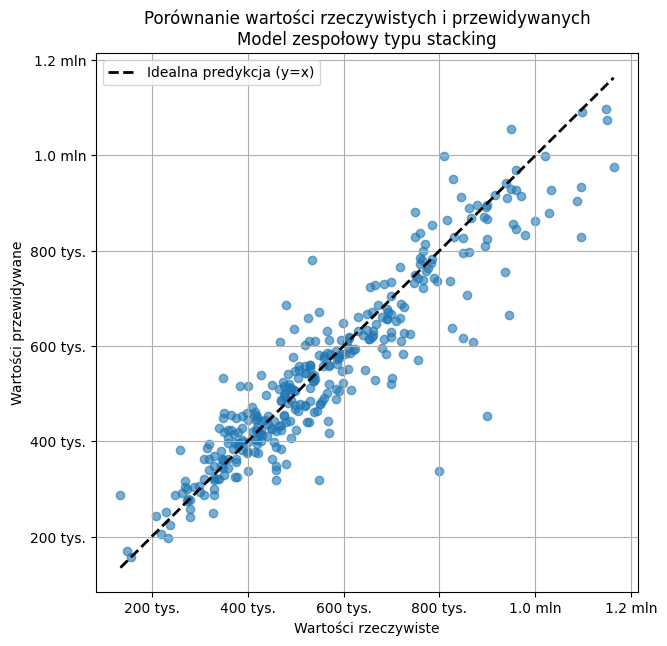

In [39]:
plt.figure(figsize=(7,7))
plt.scatter(y_test_true, y_pred, alpha=0.6)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()],  'k--', lw=2, label="Idealna predykcja (y=x)")
plt.xlabel("Wartości rzeczywiste")
plt.ylabel("Wartości przewidywane")
plt.title("Porównanie wartości rzeczywistych i przewidywanych\nModel zespołowy typu stacking")
plt.legend()
plt.grid(True)

# Nowy format osi
def custom_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000} mln'
    else:
        return f'{int(x/1000)} tys.'

axes = plt.gca()
axes.xaxis.set_major_formatter(ticker.FuncFormatter(custom_format))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(custom_format))

plt.show()


In [ ]:
ridge_model = Ridge()
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

_, result = tune_and_evaluate(
    name="Ridge",
    model=ridge_model,
    param_grid=ridge_param_grid,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    search_type="grid"
)

results_tuned.append(result)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

📊 Ridge
Najlepsze parametry: {'alpha': 1}
R²: 0.7782
Znormalizowane MAE: 0.1331
Znormalizowane RMSE: 0.1724
MAPE: 14.42%


In [ ]:
lasso_model = Lasso(max_iter=10000)
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

_, result = tune_and_evaluate(
    name="Lasso",
    model=lasso_model,
    param_grid=lasso_param_grid,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    search_type="grid"
)

results_tuned.append(result)


Fitting 3 folds for each of 5 candidates, totalling 15 fits

📊 Lasso
Najlepsze parametry: {'alpha': 10}
R²: 0.7781
Znormalizowane MAE: 0.1332
Znormalizowane RMSE: 0.1724
MAPE: 14.43%


In [ ]:
enet_model = ElasticNet(max_iter=10000, random_state=42)
enet_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

_, result = tune_and_evaluate(
    name="ElasticNet",
    model=enet_model,
    param_grid=enet_param_grid,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    search_type="grid"
)

results_tuned.append(result)


Fitting 3 folds for each of 25 candidates, totalling 75 fits

📊 ElasticNet
Najlepsze parametry: {'alpha': 0.01, 'l1_ratio': 0.9}
R²: 0.7783
Znormalizowane MAE: 0.1331
Znormalizowane RMSE: 0.1724
MAPE: 14.41%


In [63]:
results_df = pd.DataFrame(results_tuned)
results_df = results_df.sort_values("R2", ascending=False)
results_df.reset_index(drop=True, inplace=True)

display(results_df)

,Model,MAE_norm,RMSE_norm,R2,MAPE,Best_Params,MAE,RMSE
0,XGBoost,0.095833,0.131524,0.870891,10.242981,"{'subsample': 0.8, 'n_estimators': 700, 'max_d...",NaN,NaN
1,Gradient Boosting,0.096396,0.137770,0.858339,10.178060,"{'subsample': 0.6, 'n_estimators': 1000, 'max_...",NaN,NaN
2,Stacking (log),0.096138,0.143332,0.846670,9.985237,NaN,NaN,NaN
3,Stacking (log),NaN,NaN,0.846670,9.985237,NaN,54150.25527,80732.644119
4,XGBoost (log),0.095990,0.145169,0.842714,10.033147,"{'subsample': 0.6, 'n_estimators': 700, 'max_d...",NaN,NaN
5,Random Forest,0.104646,0.147737,0.837101,11.600674,"{'n_estimators': 300, 'min_samples_split': 2, ...",NaN,NaN
6,Gradient Boosting (log),0.097833,0.149766,0.832595,10.139797,"{'subsample': 0.6, 'n_estimators': 1000, 'max_...",NaN,NaN
7,Random Forest (log),0.104162,0.152907,0.825500,10.867563,"{'n_estimators': 300, 'min_samples_split': 2, ...",NaN,NaN
8,SVR (log),0.106519,0.154583,0.821652,11.523514,"{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kern...",NaN,NaN
9,MLP,0.120616,0.164494,0.798049,13.538395,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",NaN,NaN
